In [1]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import linregress

In [2]:
## Read files and data clean
def read_satellite_data(satellite):
    # --- Main Execution ---
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    df = df[df['veg_class'].isin([11, 12, 13, 14])]
    return df

In [3]:
## Read AVHRR data, effect size data, then combine
satellite = "avhrr" 
df = read_satellite_data(satellite)

eos_cols = [col for col in df.columns if 'eos' in col]
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]

years = [str(y) for y in range(1982, 2017)]
cols = years
# df = df[[col for col in eos_cols + t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'/D*(/d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
df_climate = df[['annual_t', 'annual_p', 'latitude', 'longitude']]

import glob
import os
# Path to folder containing CSVs
path = "../data/effect_size/avhrr/mv"

csv_files = sorted(glob.glob(os.path.join(path, "*.csv")))
dfs = []
for f in csv_files:
    df = pd.read_csv(f)
    # Drop columns that end with "_p"
    df = df.loc[:, ~df.columns.str.endswith("_p")]
    dfs.append(df)
effect_size = pd.concat(dfs, axis=0, ignore_index=True)
# print(effect_size)

effect_size = pd.merge(effect_size, df_climate, on=['latitude', 'longitude'], how='inner')

In [4]:
## Years & moving windows
def get_years_and_windows(name, mv):
    years = list(range(1982, 2017))
    windows = [(start, start + 14) for start in range(1982, 2003)]

    return years, windows

In [5]:
## Plot moving window effects
def plot_effect_boxplot(df_effects, var, windows, interval=4):
    if windows is None:
        raise ValueError("You must provide a 'windows' list.")

    cols = sorted(
        [col for col in df_effects.columns if col.startswith(f'{var}_es_w')],
        key=lambda x: int(x.split('_w')[-1])
    )

    central_years = [int((start + end) / 2) for start, end in windows]
    data = [df_effects[col].dropna().values for col in cols]

    fig, ax = plt.subplots(figsize=(6, 4))

    # Boxplot first
    bp = ax.boxplot(
        data,
        patch_artist=True,
        showfliers=False,
        capprops=dict(visible=False),
        whiskerprops=dict(color='black', linewidth=0.6),
        boxprops=dict(facecolor='#66b3e0', color='black', linewidth=0.6),
        medianprops=dict(color='black'),
        zorder=1,  # lower zorder for boxes
        widths=0.6,
        whis=1.0  # <--- shorten whiskers to 1x IQR
    )
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colors = ["#2066a8", "#4d91c4", "#8ec1da", "#cde1ec", "#ededed", "#f6d6c2", "#d47264"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors)
    N = len(bp['boxes'])
    color_list = [cmap(i / (N - 1)) for i in range(N)]
    for patch, color in zip(bp['boxes'], color_list):
        patch.set_facecolor(color)

    x_pos = list(range(1, len(central_years) + 1))
    # tick_labels = [str(year) if i % interval == 0 else '' for i, year in enumerate(central_years)]
    # ax.set_xticks(x_pos)
    # ax.set_xticklabels(tick_labels, rotation=45)

    xticks_pos = [x_pos[i] for i in range(len(central_years)) if i % interval == 0]
    xticks_labels = [str(central_years[i]) for i in range(len(central_years)) if i % interval == 0]
    ax.set_xticks(xticks_pos)
    ax.set_xticklabels(xticks_labels, rotation=45)

    ax.set_xlabel('Central Year of Moving Window', fontsize=14)
    ax.set_ylabel('Effect Size', fontsize=14)
    # ax.set_title(f'{var.capitalize()} Effect Size Across Moving Windows')
    ax.grid(False)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(-2, 2.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_yticks([-2, -1, 0, 1, 2])
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    # Calculate mean for each window (box)
    means = np.array([np.mean(d) for d in data])

    # Plot means as black 'x' markers ON TOP of boxes
    ax.scatter(x_pos, means, color='black', marker='x', s=30, zorder=3)

    # Linear regression on means vs central years
    valid_idx = ~np.isnan(means)
    x_years = np.array(central_years)[valid_idx]
    y_means = means[valid_idx]
    def format_p(p):
        if p < 0.01:
            return "p<0.01"
        elif p < 0.05:
            return "p<0.05"
        else:
            return f"p={p:.2f}"
    if len(x_years) > 1:
        res = linregress(x_years, y_means)
        # Regression line points over full range of x_pos
        y_fit = res.slope * np.array(central_years) + res.intercept
        ax.plot(x_pos, y_fit, '--', color='#e03c31', zorder=2)  # above box but below markers
        # Add text in upper right corner
        textstr = f'Slope = {res.slope:.3f}, R² = {res.rvalue**2:.2f}, {format_p(res.pvalue)}'
        ax.text(
            0.98, 0.98, textstr,
            transform=ax.transAxes,
            fontsize=12,
            va='top',
            ha='right',
        )

    # ax.legend()
    plt.tight_layout()
    if var == "sos":
        ax.text(0.01, 0.95, 'SOS', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "spring_t":
        ax.text(0.01, 0.95, 'Spring T', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "summer_t":
        ax.text(0.01, 0.95, 'Summer T', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "autumn_t":
        ax.text(0.01, 0.95, 'Autumn T', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')

    elif var == "spring_p":
        ax.text(0.01, 0.95, 'Spring P', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "summer_p":
        ax.text(0.01, 0.95, 'Summer P', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "autumn_p":
        ax.text(0.01, 0.95, 'Autumn P', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')

    elif var == "spring_r":
        ax.text(0.01, 0.95, 'Spring SR', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "summer_r":
        ax.text(0.01, 0.95, 'Summer SR', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "autumn_r":
        ax.text(0.01, 0.95, 'Autumn SR', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    return plt.gcf()

    # plt.show()


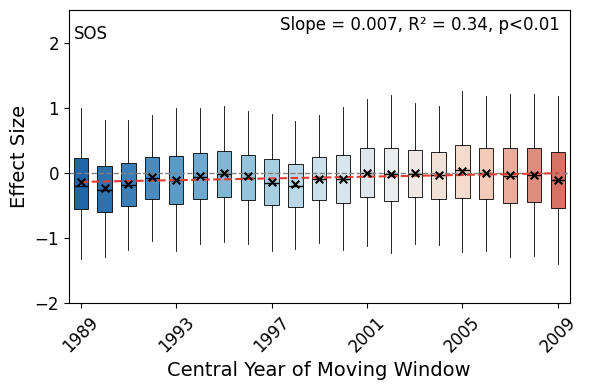

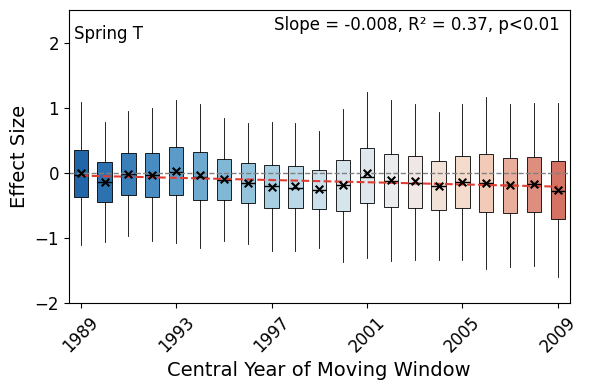

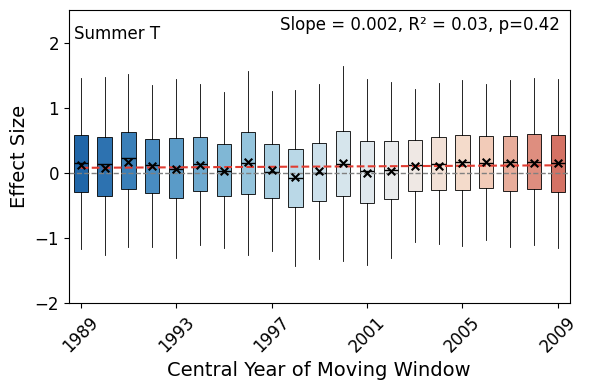

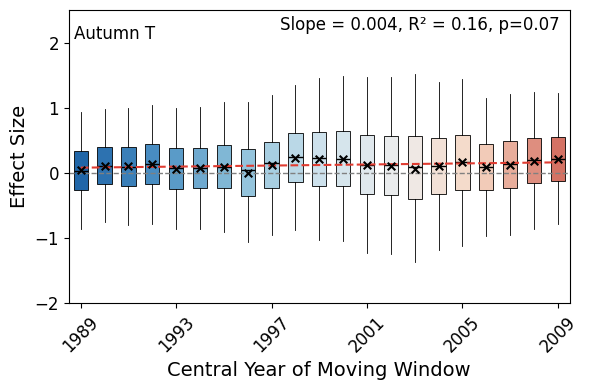

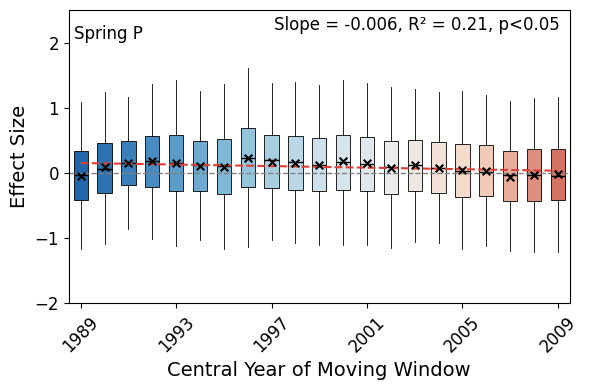

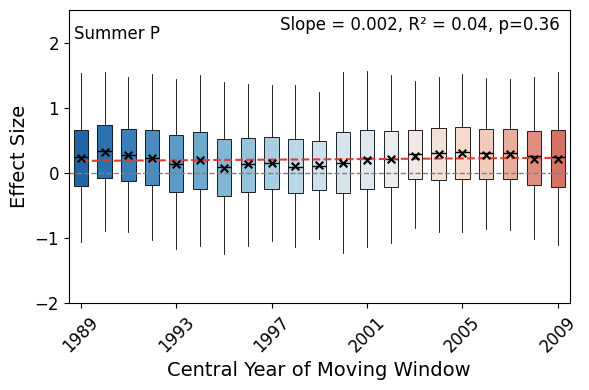

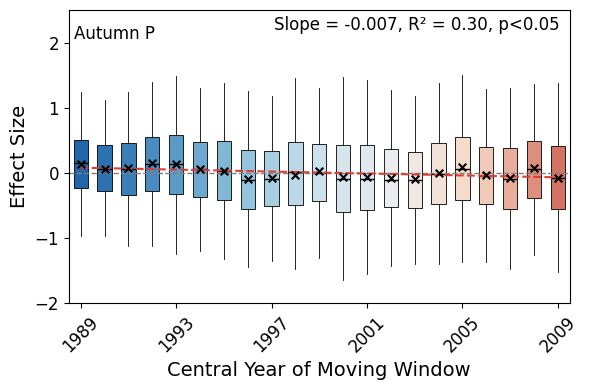

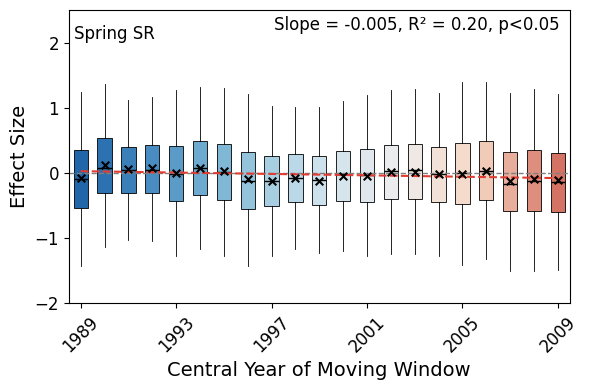

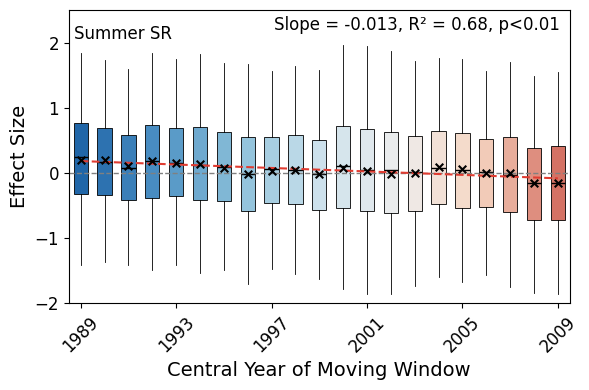

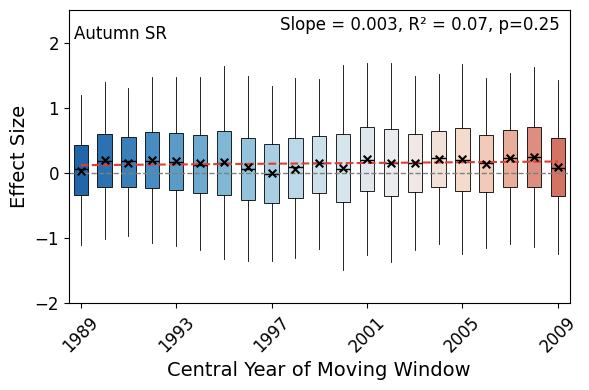

In [6]:
## Plot hot-dry regions
mv = (1982, 1990) ## max 2002
years, windows = get_years_and_windows(satellite, mv)
effect_size_low_prcp = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] > 7.25)]
fig_sos = plot_effect_boxplot(effect_size_low_prcp, 'sos', windows, interval=4)

fig_spring_t = plot_effect_boxplot(effect_size_low_prcp, 'spring_t', windows, interval=4)
fig_summer_t = plot_effect_boxplot(effect_size_low_prcp, 'summer_t', windows, interval=4)
fig_autumn_t = plot_effect_boxplot(effect_size_low_prcp, 'autumn_t', windows, interval=4)
fig_spring_p = plot_effect_boxplot(effect_size_low_prcp, 'spring_p', windows, interval=4)
fig_summer_p = plot_effect_boxplot(effect_size_low_prcp, 'summer_p', windows, interval=4)
fig_autumn_p = plot_effect_boxplot(effect_size_low_prcp, 'autumn_p', windows, interval=4)
fig_spring_r = plot_effect_boxplot(effect_size_low_prcp, 'spring_r', windows, interval=4)
fig_summer_r = plot_effect_boxplot(effect_size_low_prcp, 'summer_r', windows, interval=4)
fig_autumn_r = plot_effect_boxplot(effect_size_low_prcp, 'autumn_r', windows, interval=4)

fig_sos.savefig("../results/si_figures/si_fig12-14/hot_dry/sos_mv.png", dpi=300, bbox_inches='tight')
fig_spring_t.savefig("../results/si_figures/si_fig12-14/hot_dry/spring_t_mv.png", dpi=300, bbox_inches='tight')
fig_summer_t.savefig("../results/si_figures/si_fig12-14/hot_dry/summer_t_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_t.savefig("../results/si_figures/si_fig12-14/hot_dry/autumn_t_mv.png", dpi=300, bbox_inches='tight')
fig_spring_p.savefig("../results/si_figures/si_fig12-14/hot_dry/spring_p_mv.png", dpi=300, bbox_inches='tight')
fig_summer_p.savefig("../results/si_figures/si_fig12-14/hot_dry/summer_p_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_p.savefig("../results/si_figures/si_fig12-14/hot_dry/autumn_p_mv.png", dpi=300, bbox_inches='tight')
fig_spring_r.savefig("../results/si_figures/si_fig12-14/hot_dry/spring_r_mv.png", dpi=300, bbox_inches='tight')
fig_summer_r.savefig("../results/si_figures/si_fig12-14/hot_dry/summer_r_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_r.savefig("../results/si_figures/si_fig12-14/hot_dry/autumn_r_mv.png", dpi=300, bbox_inches='tight')

In [7]:
## Plot moving window effects
def plot_effect_boxplot(df_effects, var, windows, interval=4):
    if windows is None:
        raise ValueError("You must provide a 'windows' list.")

    cols = sorted(
        [col for col in df_effects.columns if col.startswith(f'{var}_es_w')],
        key=lambda x: int(x.split('_w')[-1])
    )

    central_years = [int((start + end) / 2) for start, end in windows]
    data = [df_effects[col].dropna().values for col in cols]

    fig, ax = plt.subplots(figsize=(6, 4))

    # Boxplot first
    bp = ax.boxplot(
        data,
        patch_artist=True,
        showfliers=False,
        capprops=dict(visible=False),
        whiskerprops=dict(color='black', linewidth=0.6),
        boxprops=dict(facecolor='#66b3e0', color='black', linewidth=0.6),
        medianprops=dict(color='black'),
        zorder=1,  # lower zorder for boxes
        widths=0.6,
        whis=1.0  # <--- shorten whiskers to 1x IQR
    )
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colors = ["#2066a8", "#4d91c4", "#8ec1da", "#cde1ec", "#ededed", "#f6d6c2", "#d47264"]
    # colors.reverse()

    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors)
    N = len(bp['boxes'])
    color_list = [cmap(i / (N - 1)) for i in range(N)]
    for patch, color in zip(bp['boxes'], color_list):
        patch.set_facecolor(color)

    x_pos = list(range(1, len(central_years) + 1))
    # tick_labels = [str(year) if i % interval == 0 else '' for i, year in enumerate(central_years)]
    # ax.set_xticks(x_pos)
    # ax.set_xticklabels(tick_labels, rotation=45)

    xticks_pos = [x_pos[i] for i in range(len(central_years)) if i % interval == 0]
    xticks_labels = [str(central_years[i]) for i in range(len(central_years)) if i % interval == 0]
    ax.set_xticks(xticks_pos)
    ax.set_xticklabels(xticks_labels, rotation=45)

    ax.set_xlabel('Central Year of Moving Window', fontsize=14)
    ax.set_ylabel('Effect Size', fontsize=14)
    # ax.set_title(f'{var.capitalize()} Effect Size Across Moving Windows')
    ax.grid(False)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(-2, 2.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_yticks([-2, -1, 0, 1, 2])
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    # Calculate mean for each window (box)
    means = np.array([np.mean(d) for d in data])

    # Plot means as black 'x' markers ON TOP of boxes
    ax.scatter(x_pos, means, color='black', marker='x', s=30, zorder=3)

    # Linear regression on means vs central years
    valid_idx = ~np.isnan(means)
    x_years = np.array(central_years)[valid_idx]
    y_means = means[valid_idx]
    def format_p(p):
        if p < 0.01:
            return "p<0.01"
        elif p < 0.05:
            return "p<0.05"
        else:
            return f"p={p:.2f}"
    if len(x_years) > 1:
        res = linregress(x_years, y_means)
        # Regression line points over full range of x_pos
        y_fit = res.slope * np.array(central_years) + res.intercept
        ax.plot(x_pos, y_fit, '--', color='#e03c31', zorder=2)  # above box but below markers
        # Add text in upper right corner
        textstr = f'Slope = {res.slope:.3f}, R² = {res.rvalue**2:.2f}, {format_p(res.pvalue)}'
        ax.text(
            0.98, 0.98, textstr,
            transform=ax.transAxes,
            fontsize=12,
            va='top',
            ha='right',
        )

    # ax.legend()
    plt.tight_layout()
    if var == "sos":
        ax.text(0.01, 0.95, 'SOS', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "spring_t":
        ax.text(0.01, 0.95, 'Spring T', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "summer_t":
        ax.text(0.01, 0.95, 'Summer T', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "autumn_t":
        ax.text(0.01, 0.95, 'Autumn T', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')

    elif var == "spring_p":
        ax.text(0.01, 0.95, 'Spring P', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "summer_p":
        ax.text(0.01, 0.95, 'Summer P', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "autumn_p":
        ax.text(0.01, 0.95, 'Autumn P', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')

    elif var == "spring_r":
        ax.text(0.01, 0.95, 'Spring SR', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "summer_r":
        ax.text(0.01, 0.95, 'Summer SR', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    elif var == "autumn_r":
        ax.text(0.01, 0.95, 'Autumn SR', transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top')
    return plt.gcf()

    # plt.show()


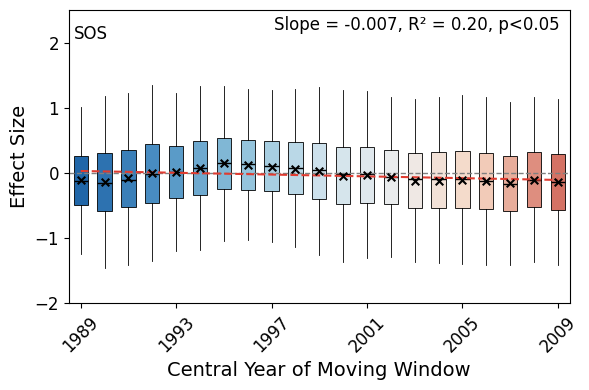

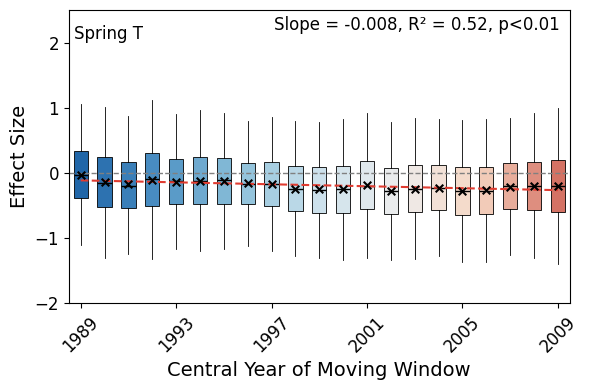

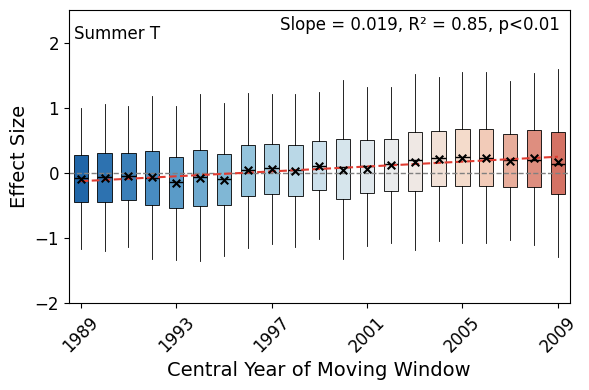

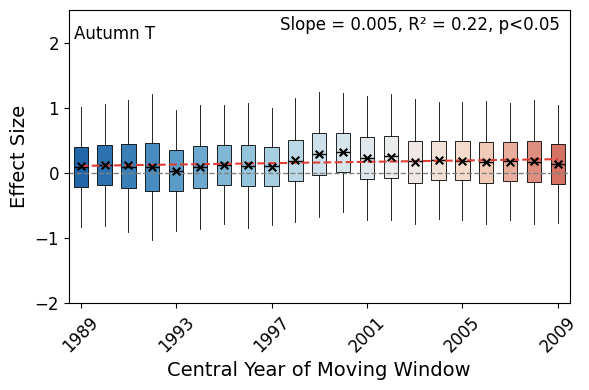

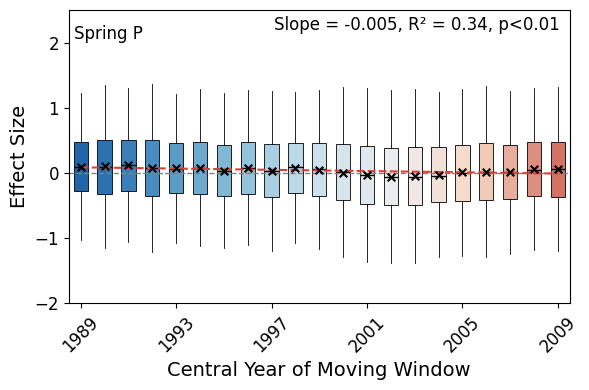

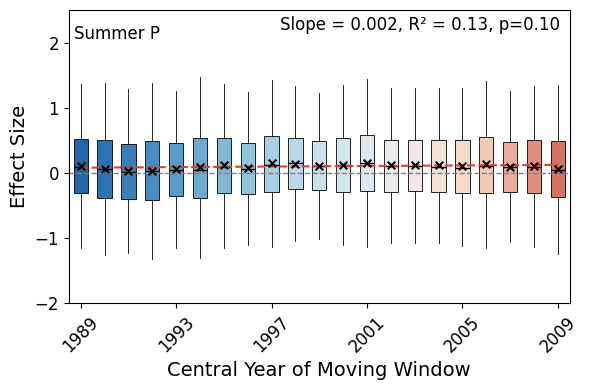

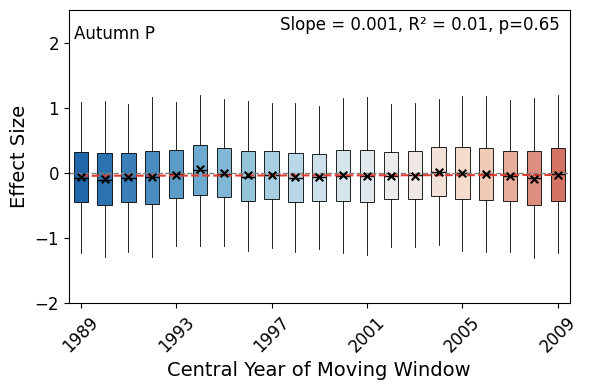

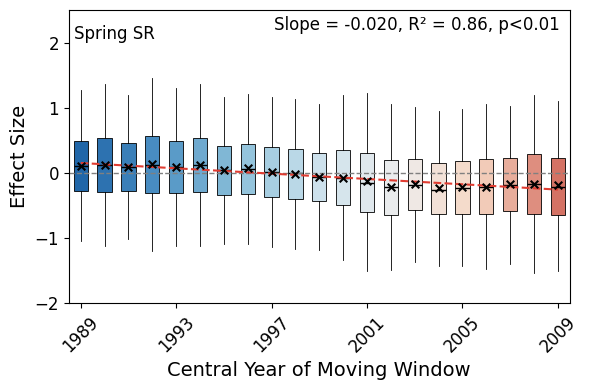

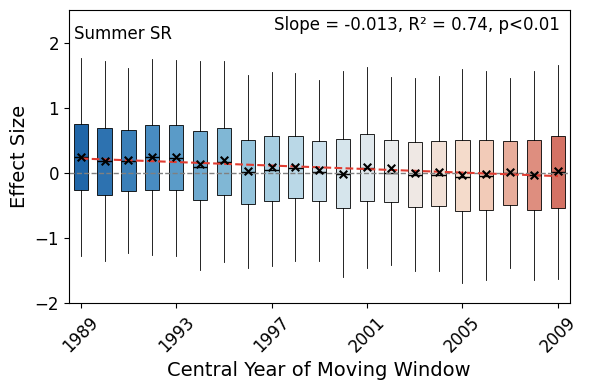

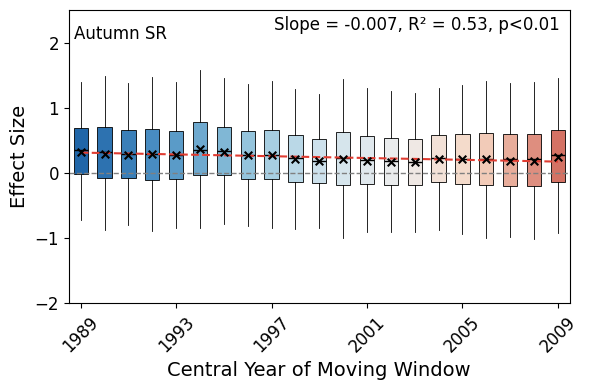

In [8]:
## plot cold-dry regions
mv = (1982, 1990) ## max 2002
years, windows = get_years_and_windows(satellite, mv)
effect_size_low_prcp = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] < 7.25)]
fig_sos = plot_effect_boxplot(effect_size_low_prcp, 'sos', windows, interval=4)
fig_spring_t = plot_effect_boxplot(effect_size_low_prcp, 'spring_t', windows, interval=4)
fig_summer_t = plot_effect_boxplot(effect_size_low_prcp, 'summer_t', windows, interval=4)
fig_autumn_t = plot_effect_boxplot(effect_size_low_prcp, 'autumn_t', windows, interval=4)
fig_spring_p = plot_effect_boxplot(effect_size_low_prcp, 'spring_p', windows, interval=4)
fig_summer_p = plot_effect_boxplot(effect_size_low_prcp, 'summer_p', windows, interval=4)
fig_autumn_p = plot_effect_boxplot(effect_size_low_prcp, 'autumn_p', windows, interval=4)
fig_spring_r = plot_effect_boxplot(effect_size_low_prcp, 'spring_r', windows, interval=4)
fig_summer_r = plot_effect_boxplot(effect_size_low_prcp, 'summer_r', windows, interval=4)
fig_autumn_r = plot_effect_boxplot(effect_size_low_prcp, 'autumn_r', windows, interval=4)

fig_sos.savefig("../results/si_figures/si_fig12-14/cold_dry/sos_mv.png", dpi=300, bbox_inches='tight')
fig_spring_t.savefig("../results/si_figures/si_fig12-14/cold_dry/spring_t_mv.png", dpi=300, bbox_inches='tight')
fig_summer_t.savefig("../results/si_figures/si_fig12-14/cold_dry/summer_t_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_t.savefig("../results/si_figures/si_fig12-14/cold_dry/autumn_t_mv.png", dpi=300, bbox_inches='tight')
fig_spring_p.savefig("../results/si_figures/si_fig12-14/cold_dry/spring_p_mv.png", dpi=300, bbox_inches='tight')
fig_summer_p.savefig("../results/si_figures/si_fig12-14/cold_dry/summer_p_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_p.savefig("../results/si_figures/si_fig12-14/cold_dry/autumn_p_mv.png", dpi=300, bbox_inches='tight')
fig_spring_r.savefig("../results/si_figures/si_fig12-14/cold_dry/spring_r_mv.png", dpi=300, bbox_inches='tight')
fig_summer_r.savefig("../results/si_figures/si_fig12-14/cold_dry/summer_r_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_r.savefig("../results/si_figures/si_fig12-14/cold_dry/autumn_r_mv.png", dpi=300, bbox_inches='tight')

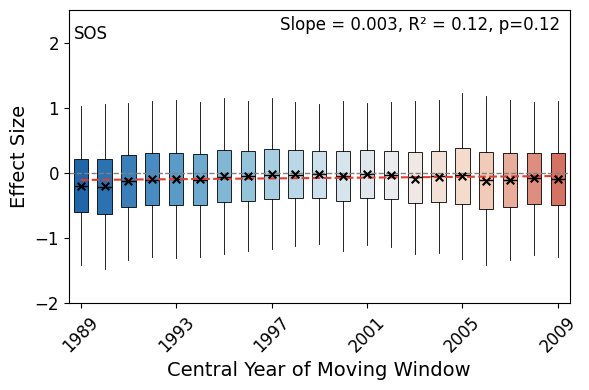

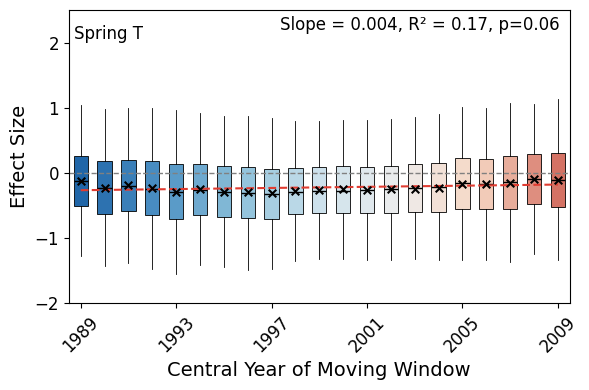

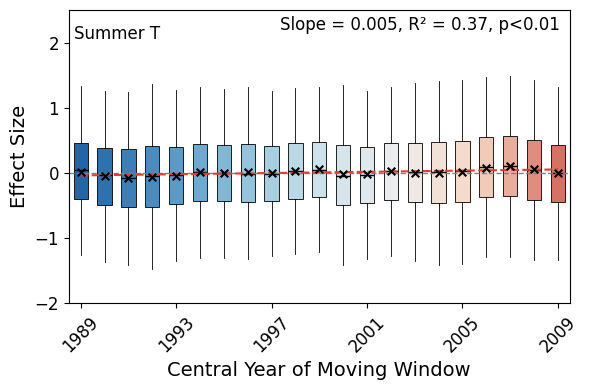

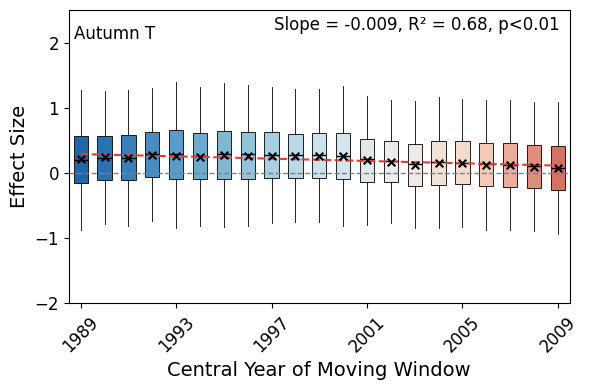

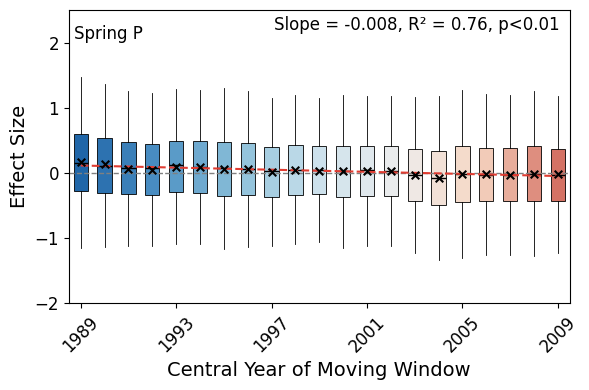

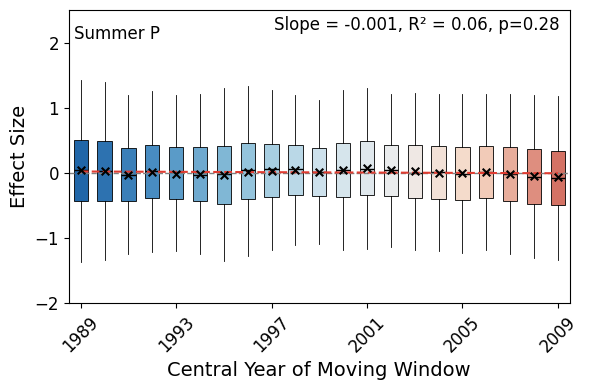

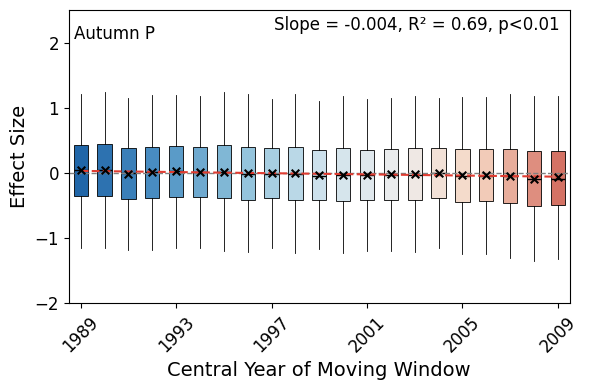

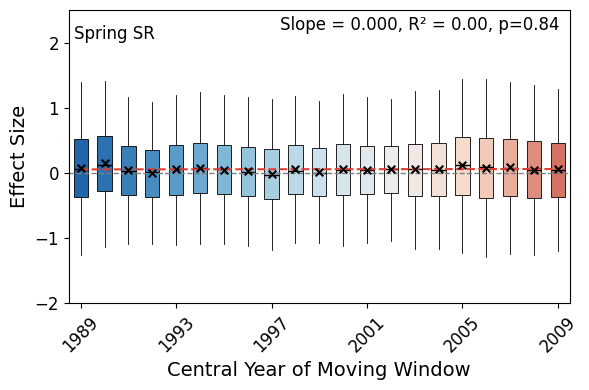

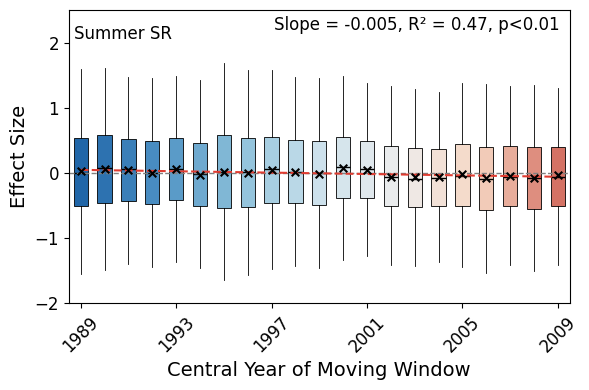

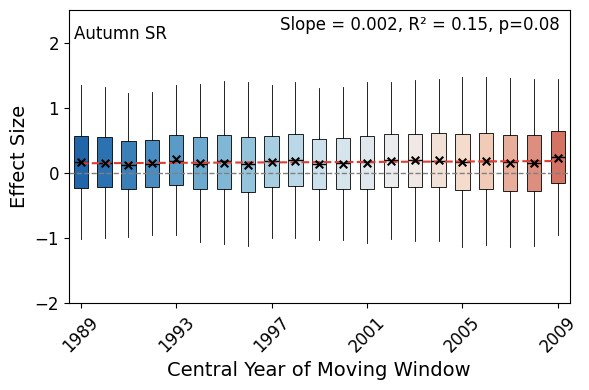

In [9]:
## plot wet regions
mv = (1982, 1990) ## max 2002
years, windows = get_years_and_windows(satellite, mv)
effect_size_wet = effect_size[effect_size['annual_p'] > 0.9]
fig_sos = plot_effect_boxplot(effect_size_wet, 'sos', windows, interval=4)
fig_spring_t = plot_effect_boxplot(effect_size_wet, 'spring_t', windows, interval=4)
fig_summer_t = plot_effect_boxplot(effect_size_wet, 'summer_t', windows, interval=4)
fig_autumn_t = plot_effect_boxplot(effect_size_wet, 'autumn_t', windows, interval=4)
fig_spring_p = plot_effect_boxplot(effect_size_wet, 'spring_p', windows, interval=4)
fig_summer_p = plot_effect_boxplot(effect_size_wet, 'summer_p', windows, interval=4)
fig_autumn_p = plot_effect_boxplot(effect_size_wet, 'autumn_p', windows, interval=4)
fig_spring_r = plot_effect_boxplot(effect_size_wet, 'spring_r', windows, interval=4)
fig_summer_r = plot_effect_boxplot(effect_size_wet, 'summer_r', windows, interval=4)
fig_autumn_r = plot_effect_boxplot(effect_size_wet, 'autumn_r', windows, interval=4)

fig_sos.savefig("../results/si_figures/si_fig12-14/wet/sos_mv.png", dpi=300, bbox_inches='tight')
fig_spring_t.savefig("../results/si_figures/si_fig12-14/wet/spring_t_mv.png", dpi=300, bbox_inches='tight')
fig_summer_t.savefig("../results/si_figures/si_fig12-14/wet/summer_t_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_t.savefig("../results/si_figures/si_fig12-14/wet/autumn_t_mv.png", dpi=300, bbox_inches='tight')
fig_spring_p.savefig("../results/si_figures/si_fig12-14/wet/spring_p_mv.png", dpi=300, bbox_inches='tight')
fig_summer_p.savefig("../results/si_figures/si_fig12-14/wet/summer_p_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_p.savefig("../results/si_figures/si_fig12-14/wet/autumn_p_mv.png", dpi=300, bbox_inches='tight')
fig_spring_r.savefig("../results/si_figures/si_fig12-14/wet/spring_r_mv.png", dpi=300, bbox_inches='tight')
fig_summer_r.savefig("../results/si_figures/si_fig12-14/wet/summer_r_mv.png", dpi=300, bbox_inches='tight')
fig_autumn_r.savefig("../results/si_figures/si_fig12-14/wet/autumn_r_mv.png", dpi=300, bbox_inches='tight')